# References:

Torchvision models: https://pytorch.org/vision/stable/models.html

VGG16 pre-trained: https://worksheets.codalab.org/worksheets/0xe2ac460eee7443438d5ab9f43824a819

How to freeze the layers:
https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/

https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch

https://debuggercafe.com/transfer-learning-with-pytorch/

Danni Chen\09/24/2021

In [1]:
import torchvision.models as models
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#torch
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

# Import torch.nn which contains all functions necessary to define a convolutional neural network
import torch.nn as nn

# Import NiFTIDataset to access the train_test_split method and the NiFTIDataset class
import import_ipynb
from NiFTIDataset import train_test_split
from NiFTIDataset import NiFTIDataset

importing Jupyter notebook from NiFTIDataset.ipynb


# Retrieve Dataset from Metadata Dataframe and Load with Dataloader

Number of data in the training dataset: 887
Number of data in the testing dataset: 223

{'image': tensor([[-2048., -2048., -2048.,  ..., -2048., -2048., -2048.],
        [-2048., -2048., -2048.,  ..., -2048., -2048., -2048.],
        [-2048., -2048., -2048.,  ..., -2048., -2048., -2048.],
        ...,
        [-2048., -2048., -2048.,  ..., -2048., -2048., -2048.],
        [-2048., -2048., -2048.,  ..., -2048., -2048., -2048.],
        [-2048., -2048., -2048.,  ..., -2048., -2048., -2048.]],
       dtype=torch.float64), 'label': 3}


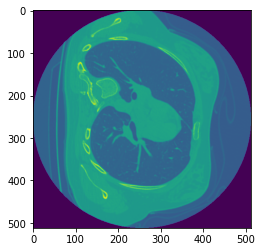

In [2]:
# MetaData dataframe
metadata = pd.read_csv("metadata.csv")

# Retrieve the dataset from info obtained in metadata dataframe
dataset = NiFTIDataset(metadata=metadata,root='.',transform=None)

# Split a NiFTIDatset into two groups (training and testing) based on information specified within its metadata dataframe
# Return a tuple containing two NiFTIDataset objects with training and testing data, respectively.
(training_data,testing_data) = train_test_split(dataset)

print('Number of data in the training dataset: ' + str(len(training_data)))
print('Number of data in the testing dataset: ' + str(len(testing_data)) + '\n')

# Visualize the 886th image in the training dataset
t = training_data.__getitem__(886)
print(t)

# load the data with dataloader
train_dataloader = DataLoader(training_data,batch_size=64,shuffle=True)
test_dataloader = DataLoader(testing_data,batch_size=64,shuffle=False)

plt.imshow(t['image'])

# Initialize Pre-Trained VGG16, Freeze all Layers Except for FC Layer

In [3]:
# Initialize a pre-trained VGG16 object will download its weights to a cache directory.
vgg16 = models.vgg16(pretrained=True)

# print(vgg16.classifier[6].out_features) # 1000
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# Freeze training for all layers
# To save computation time and that the network would already be able to extract generic features from the dataset.
for param in vgg16.features.parameters():
    param.requires_grad = False    

In [5]:
# https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/
# Remove the original fully-connected layer (the last layer) and create a new one
# Newly created modules have requires_grad=True by default
num_features = vgg16.classifier[6].in_features
classifier_layers = list(vgg16.classifier.children())[:-1] # Remove the last layer
classifier_layers.extend([nn.Linear(in_features = num_features, out_features= 2)]) # Add the new layer with outputting 2 categories
vgg16.classifier = nn.Sequential(*classifier_layers) # Replace the model classifier, Overwriting the original

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Set Loss Function and Optimizer

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss() 

# Optimizer, only the parameters of the classifier are optimized
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

# optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Model Training

In [21]:
# training
# train for 2 epochs
for epoch in range(2): 

    # initiate running_loss
    running_loss = 0.0 

    for ith_batch,batch_data in enumerate(train_dataloader): 
        # obtain the images and labels
        img_batch,labels_batch = batch_data['image'],batch_data['label']
        
        print(img_batch.shape) # torch.Size([64, 512, 512]) # gray-scale image has no channel
        
        # unsqueeze() method is adding a new dimension of the batch
        img_batch = img_batch.unsqueeze(1) # img_batch is a torch tensor
        
        print(img_batch.shape) # torch.Size([64, 1, 512, 512])
        
        # repeat() repeats tensor along the specified dimensions. 
        # increase the dimension of the dimension
        img_batch = img_batch.repeat(1,3,1,1)
        
        print(img_batch.shape) #torch.Size([64, 3, 512, 512])

        print(labels_batch) # 64*4 # labels_batch: row-sample, colmn-class
        
        # convert the shape of labels_batch from 64*4 to be 64*2         
        # if label is 0, then (10), if label is 1,2,3, then (01)
        for 
        new_labels_batch = []
        negative = np.array([1, 0])
        normal = torch.as_tensor(negative)
        positive = np.array([0, 1])
        abnormal = torch.as_tensor(positive)
        
        for i in labels_batch:
            if i == 0:
                new_labels_batch.append(normal)
            else:
                new_labels_batch.append(abnormal)
        new_labels_batch = torch.stack(new_labels_batch)
        print(new_labels_batch)
        
        # zero the parameter gradients (necessary because .backward() accumulate gradient for each parameter after each iteration)
        optimizer.zero_grad()

        # forward + backward + optimize
        # feed the img_batch (input) into the network
        outputs = vgg16(img_batch.float())
        print(outputs)
        print(outputs.shape) 
        print(new_labels_batch.shape)
        
        # calculate the cross-entropy loss
        loss = criterion(outputs, new_labels_batch)
        # backward
        loss.backward()
        # perform parameter update based on current gradient (stored in .grad) and update rule of SGD
        optimizer.step()

        # print statistics
        running_loss += loss.item() # .item() extracts loss values as floats
        
        # print every 10 mini-batches
        if ith_batch % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                  (epoch+1, ith_batch+1, running_loss/10))
            running_loss = 0.0

print('Finished Training')

torch.Size([64, 512, 512])
torch.Size([64, 1, 512, 512])
torch.Size([64, 3, 512, 512])
tensor([1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 3, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2,
        3, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        

RuntimeError: 1D target tensor expected, multi-target not supported

# Model Testing

In [ ]:
# Testing

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader: # iterate through the data
        images, labels = data['image'],data['label']
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # increment total and correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# print the accuracy
print('Accuracy of the networks: %d %%' % (
    100 * correct / total))